In [1]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

y_train_cls = y_train.astype(np.int32)
y_test_cls = y_test.astype(np.int32) 

y_train = np.eye(10)[y_train].astype(np.float32)
y_test = np.eye(10)[y_test].astype(np.float32) 

print(x_train.shape, x_train.dtype) 
print(y_train.shape, y_train.dtype) 
print(y_train_cls.shape, y_train_cls.dtype) 
print(x_test.shape, x_test.dtype)  
print(y_test.shape, y_test.dtype)  
print(y_test_cls.shape, y_test_cls.dtype)

(60000, 784) float32
(60000, 10) float32
(60000,) int32
(10000, 784) float32
(10000, 10) float32
(10000,) int32


In [2]:
lr = 2e-4 
epoch = int(1e2) 
batch_size = 100

import numpy as np; np.random.seed(0)
import tensorflow as tf; tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 784)) # (?, 784)
y = tf.placeholder(tf.float32, (None, 10)) # (?, 10)
y_cls = tf.placeholder(tf.int32, (None,)) # (?,)

init_w = tf.keras.initializers.VarianceScaling(seed=0)
init_b = tf.keras.initializers.zeros()

w1 = tf.get_variable('w1', (784, 100), tf.float32, init_w)
b1 = tf.get_variable('b1', (100,), tf.float32, init_b)

w2 = tf.get_variable('w2', (100, 50), tf.float32, init_w)
b2 = tf.get_variable('b2', (50,), tf.float32, init_b)

w3 = tf.get_variable('w3', (50, 10), tf.float32, init_w)
b3 = tf.get_variable('b3', (10,), tf.float32, init_b)

x1 = tf.nn.relu(x @ w1 + b1) 
x2 = tf.nn.relu(x1 @ w2 + b2)
logits = x2 @ w3 + b3 
entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, 
                                                     logits=logits) # (?,)
loss = tf.reduce_mean(entropy) # ()

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), 
                     tf.int32, name='y_pred_cls') # (?,) int32
correct_bool = tf.equal(y_pred_cls, y_cls, 
                        name='correct_bool') # (?,) bool
accuracy = tf.reduce_mean(tf.cast(correct_bool, tf.float32), 
                          name='accuracy') # () float32

init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
with tf.Session() as sess:
    
    sess.run(init)
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        
        x_epoch = x_train[idx]
        y_epoch = y_train[idx]
        y_cls_epoch = y_train_cls[idx]
        
        for k in range(x_train.shape[0]//batch_size):
            
            if k==0:
                loss_temp = []
                accuracy_temp = []
                
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            y_batch = y_epoch[k*batch_size:(k+1)*batch_size]
            y_cls_batch = y_cls_epoch[k*batch_size:(k+1)*batch_size]
            
            feed_dict = {x:x_batch, y:y_batch, y_cls:y_cls_batch}
            
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], 
                                                 feed_dict=feed_dict)
            
            loss_temp.append(loss_run) 
            accuracy_temp.append(accuracy_run)
        
        loss_avg = np.array(loss_temp).mean()
        accuracy_avg = np.array(accuracy_temp).mean()
        loss_trace.append(loss_avg)
        accuracy_trace.append(accuracy_avg)
        print(f'{i+1}/{epoch} loss {loss_avg}, accuracy {accuracy_avg} ')
    
    feed_dict = {x:x_test, y:y_test, y_cls:y_test_cls}
    accuracy_run, y_test_cls_pred = sess.run([accuracy, y_pred_cls], 
                                             feed_dict=feed_dict)

1/100 loss 0.7181732058525085, accuracy 0.8208999633789062 
2/100 loss 0.2768211364746094, accuracy 0.9219000339508057 
3/100 loss 0.21927663683891296, accuracy 0.9375166893005371 
4/100 loss 0.18583577871322632, accuracy 0.9470666646957397 
5/100 loss 0.1618032306432724, accuracy 0.9539833664894104 
6/100 loss 0.14413708448410034, accuracy 0.9585833549499512 
7/100 loss 0.13004659116268158, accuracy 0.9630166888237 
8/100 loss 0.11744493991136551, accuracy 0.966583251953125 
9/100 loss 0.10681916773319244, accuracy 0.9692000150680542 
10/100 loss 0.09780516475439072, accuracy 0.9717667698860168 
11/100 loss 0.08995036780834198, accuracy 0.9740000367164612 
12/100 loss 0.08239495754241943, accuracy 0.9765334129333496 
13/100 loss 0.07600761204957962, accuracy 0.977899968624115 
14/100 loss 0.07059333473443985, accuracy 0.9797666668891907 
15/100 loss 0.06564871966838837, accuracy 0.981416642665863 
16/100 loss 0.06092951446771622, accuracy 0.9824500679969788 
17/100 loss 0.056727498769

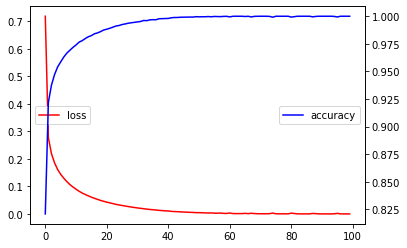

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.plot(loss_trace, color='red', label='loss')
plt.legend(loc='center left')

ax2 = ax1.twinx() 
ax2.plot(accuracy_trace, color='blue', label='accuracy')
plt.legend(loc='center right')

plt.show()

In [5]:
print(f'Test Period Accuracy : {accuracy_run}')

Test Period Accuracy : 0.9767000079154968


In [6]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_cls_pred)
print(cm)

[[ 970    0    0    1    1    1    3    1    3    0]
 [   0 1125    4    0    0    1    2    1    2    0]
 [   2    1 1006    4    2    0    2    8    6    1]
 [   0    0    5  987    0    4    0    4    5    5]
 [   0    0    4    1  956    0    7    3    0   11]
 [   2    0    0   11    2  863    4    1    8    1]
 [   4    2    3    0    4    5  938    1    1    0]
 [   0    6    7    4    0    1    0 1001    3    6]
 [   6    1    2   10    3    7    1    3  937    4]
 [   1    5    0    3    6    5    1    3    1  984]]


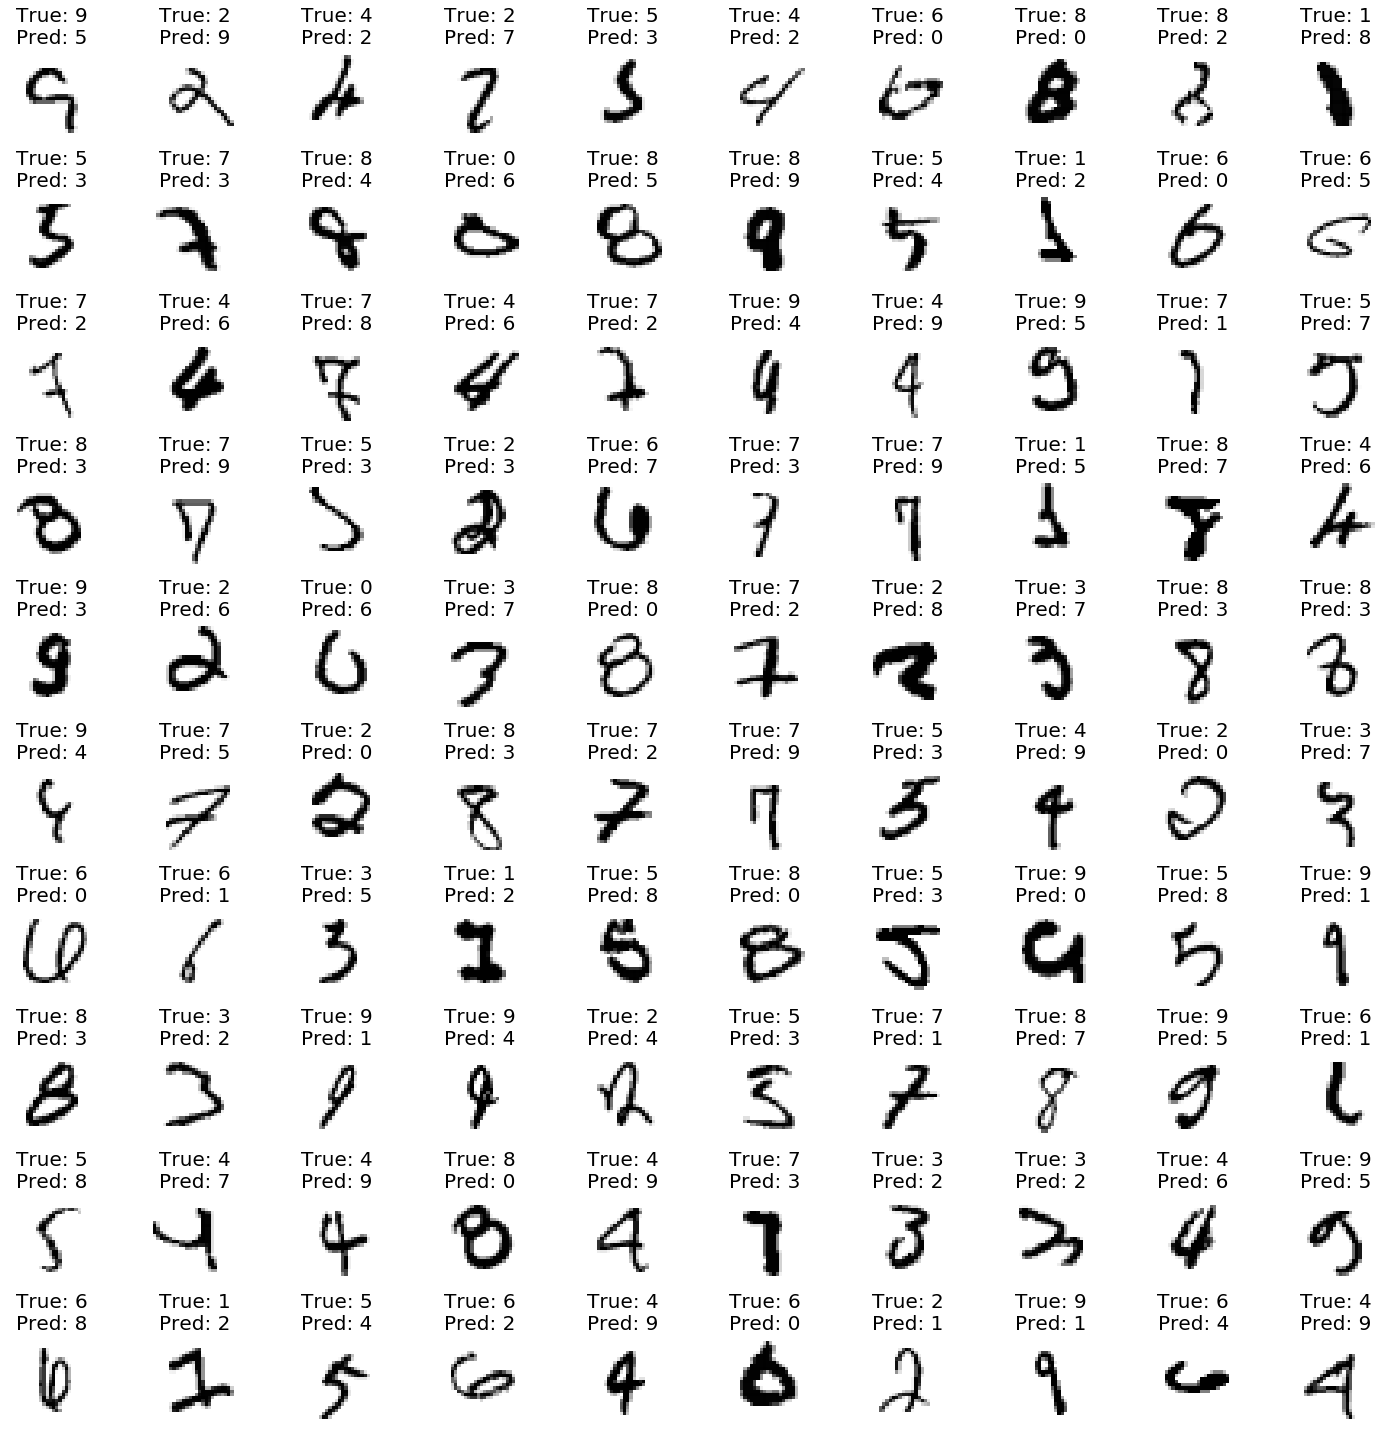

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20,20))

idx = 0
for ax in axes.reshape((-1,)): # (2, 10) ---> (20,)
    while True:
        if y_test_cls[idx]==y_test_cls_pred[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap='binary')
            true_label = y_test_cls[idx]
            pred_label = y_test_cls_pred[idx]
            title = f'True: {true_label}\nPred: {pred_label}'
            ax.set_title(title, fontsize=20)
            ax.axis('off')
            idx += 1
            break
            
plt.tight_layout()

plt.show()